In [1]:
import numpy as np
import pickle
import imageio
import os 
import torch
from diffusers import AnimateDiffPipeline, DDIMScheduler, MotionAdapter
from diffusers.utils import export_to_gif, export_to_video
from diffusers.loaders.lora_pipeline import StableDiffusionLoraLoaderMixin




d:\IPTP\3A\P2\CSC_52002\lab\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
lora_list = ["zoom-in", "zoom-out", "pan-left", "pan-right", "tilt-up", "tilt-down", "rolling-clockwise", "rolling-anticlockwise"]
prompt_list = ["masterpiece, best quality, highly detailed, ultra detailed, cherry blossom trees, petals falling, gentle breeze, spring season, tranquil park, golden sunlight, peaceful atmosphere, vibrant colors",
               "futuristic city, flying cars, neon glow, holograms, sci-fi, cyberpunk, high-tech buildings, rainy streets, reflections, ultra-detailed, cinematic lighting, masterpiece",
               "majestic snow-covered mountains, crystal-clear lake, morning mist, golden sunrise, serene landscape, pine trees, masterpiece, best quality, highly detailed, ultra realistic",
               "ancient temple ruins, overgrown vines, dense jungle, mystical atmosphere, glowing fireflies, moonlight filtering through trees, fantasy landscape, best quality, ultra detailed",
               "a cozy wooden cabin, deep in the snowy forest, warm light from windows, smoke rising from chimney, peaceful winter night, starry sky, soft snowflakes falling, high quality, ultra detailed",
               "deep underwater scene, glowing jellyfish, coral reef, vibrant marine life, sunlight filtering through the ocean, masterpiece, ultra realistic, high detail",
               "medieval castle, on top of a cliff, dramatic sky, storm approaching, lightning in the distance, cinematic atmosphere, ultra detailed, realistic, best quality",
               "a dragon soaring above a burning city, glowing red eyes, smoke and embers in the air, dramatic lighting, fantasy setting, ultra detailed, masterpiece",
               "a futuristic racing scene, high-speed hovercars, neon trails, cybernetic city backdrop, intense motion blur, ultra realistic, high detail, cinematic lighting",
               "a lone samurai standing under a cherry blossom tree, katana in hand, petals drifting in the wind, golden sunset, historical Japan, ultra detailed, masterpiece",
               "desert landscape, ancient ruins, hot sun, sand dunes, a lone traveler walking, long shadows, masterpiece, ultra detailed, cinematic composition",
               "a spaceship landing on an alien planet, strange glowing plants, massive moons in the sky, futuristic technology, sci-fi adventure, ultra realistic, high quality",
               "a giant whale swimming in the clouds, fantasy world, floating islands, warm golden sunlight, peaceful and dreamlike atmosphere, ultra detailed, masterpiece",
               "a Viking ship sailing through stormy seas, thunder and lightning, massive waves crashing, determined warriors on board, cinematic action, ultra realistic, high detail",
               "a neon-lit alleyway in a cyberpunk city, rain pouring down, reflections on the wet pavement, mysterious figure in a trench coat, atmospheric and moody, ultra detailed, cinematic",
               "a tranquil bamboo forest, soft morning light, mist rolling through, peaceful and zen-like atmosphere, ultra realistic, high detail, masterpiece",
               "an astronaut walking on Mars, vast red desert, distant mountains, dramatic lighting, cinematic science fiction, ultra realistic, masterpiece",
               "a mystical forest at twilight, bioluminescent plants, floating orbs of light, magical and otherworldly atmosphere, ultra detailed, best quality",
               "a luxury yacht sailing in a crystal blue ocean, clear sunny sky, gentle waves, people relaxing on deck, ultra realistic, high detail, cinematic",
               "a street festival at night, colorful lanterns, live performances, fireworks in the sky, people celebrating, ultra detailed, masterpiece, lively and vibrant atmosphere"]

In [10]:
combined_lora_list = ['zoom-in-pan-left',
 'zoom-in-pan-right',
 'zoom-in-tilt-up',
 'zoom-in-tilt-down',
 'zoom-in-rolling-clockwise',
 'zoom-in-rolling-anticlockwise',
 'zoom-out-pan-left',
 'zoom-out-pan-right',
 'zoom-out-tilt-up',
 'zoom-out-tilt-down',
 'zoom-out-rolling-clockwise',
 'zoom-out-rolling-anticlockwise',
 "pan-left-tilt-up",
 "pan-left-tilt-down",
 "pan-right-tilt-up",
 "pan-right-tilt-down"]  ### Exemples of combined_lora_name

In [ ]:
# (
#                 "masterpiece, bestquality, highlydetailed, ultradetailed, sunset, "
#                 "orange sky, warm lighting, fishing boats, ocean waves seagulls, "
#                 "rippling water, wharf, silhouette, serene atmosphere, dusk, evening glow, "
#                 "golden hour, coastal landscape, seaside scenery"
#             )

In [ ]:
def lora_simple_block_combine(lora_list, block = 0):
    combined_lora_list = []
    for lora_name_main in lora_list[:2]:
        dict1 = StableDiffusionLoraLoaderMixin.lora_state_dict(f"guoyww/animatediff-motion-lora-{lora_name_main}", cache_dir="./model/lora")[0]
        for lora_name_sub in lora_list[2:]:
            dict2 = StableDiffusionLoraLoaderMixin.lora_state_dict(f"guoyww/animatediff-motion-lora-{lora_name_sub}", cache_dir="./model/lora")[0]
            assert block >= 0 and block <=4
            if block != 4:
                keys = list(dict1.keys())[block*32:(block+1)*32] + list(dict1.keys())[-48*(block+1):-48*block]
            else:
                keys = list(dict1.keys())[4*32:4*32+16]
            for key in keys:
                dict1[key] = dict2[key]
            new_name = lora_name_main + "-" + lora_name_sub
            os.makedirs(f"model/lora/block{block}", exist_ok=True)
            StableDiffusionLoraLoaderMixin.save_lora_weights(f"model/lora/block{block}", dict1, weight_name = new_name + ".safetensors")
            combined_lora_list.append(new_name)
    return combined_lora_list



In [ ]:
def lora_two_blocks_combine(lora_list, blocks_list):
    combined_lora_list = []
    for block1,block2 in blocks_list:
        assert block1 >= 0 and block1 <4 and block2 >0 and block2<=4 and block1 != block2
        for lora_name_main in lora_list[:2]:
            dict1 = StableDiffusionLoraLoaderMixin.lora_state_dict(f"guoyww/animatediff-motion-lora-{lora_name_main}", cache_dir="./model/lora")[0]
            for lora_name_sub in lora_list[2:]:
                dict2 = StableDiffusionLoraLoaderMixin.lora_state_dict(f"guoyww/animatediff-motion-lora-{lora_name_sub}", cache_dir="./model/lora")[0]
                keys1 = list(dict1.keys())[block1*32:(block1+1)*32] + list(dict1.keys())[-48*(block1+1):-48*block1]
                if block2 != 4:
                    keys2 = list(dict1.keys())[block2*32:(block2+1)*32] + list(dict1.keys())[-48*(block2+1):-48*block2]
                else:
                    keys2 = list(dict1.keys())[4*32:4*32+16]
                keys = keys1 + keys2
                for key in keys:
                    dict1[key] = dict2[key]
                new_name = lora_name_main + "-" + lora_name_sub
                os.makedirs(f"model/lora/blocks{block1}_{block2}", exist_ok=True)
                StableDiffusionLoraLoaderMixin.save_lora_weights(f"model/lora/blocks{block1}_{block2}", dict1, weight_name = new_name + ".safetensors")
                combined_lora_list.append(new_name)
    return combined_lora_list

In [ ]:
def motion_two_blocks_combine(combined_lora_list, prompt_list, blocks_list, samples_per_lora_per_prompt, device=torch.device("cuda")):
    pass

In [4]:
combined_lora_list = lora_simple_block_combine(["pan-left", "pan-right", "tilt-up", "tilt-down"], block = 0)
print(combined_lora_list)

['pan-left-tilt-up', 'pan-left-tilt-down', 'pan-right-tilt-up', 'pan-right-tilt-down']


In [ ]:
def motion_simple(lora_name : str, prompt : str, sample_num :int = 1, device = torch.device("cuda")):
    adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16, cache_dir="./model/domain_adapter").to(device)
    model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
    pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter, torch_dtype=torch.float16, cache_dir="./model/image_motion").to(device)
    pipe.load_lora_weights("guoyww/animatediff-motion-lora-" + lora_name, adapter_name=lora_name, cache_dir="./model/lora") 
    scheduler = DDIMScheduler.from_pretrained(
            model_id,
            subfolder="scheduler",
            clip_sample=False,
            beta_schedule="linear",
            timestep_spacing="linspace",
            steps_offset=1,)
    pipe.scheduler = scheduler
    pipe.enable_vae_slicing()
    pipe.enable_model_cpu_offload()
    output = []
    for num in range(sample_num):
        output_unit = pipe(
            height = 256,
            width = 256,
            prompt = prompt,
            negative_prompt="bad quality, worse quality",
            num_frames=16,
            guidance_scale=7.5,
            num_inference_steps=30,
            output_type = "pil",)
        #'np', 'pt', 'pil'
        output.append(output_unit.frames[0])
    # for i in range(sample_num):
    #     np.save(f"data/generated/{lora_name}/prompt_1_array_{i}.npy", output[i])
    os.makedirs(f"data/generated/mp4/{lora_name}", exist_ok=True)
    for i in range(sample_num):
        export_to_video(output[i], f"data/generated/mp4/{lora_name}/prompt_1_video_{i}.mp4")
    return output_unit

In [ ]:
def motion_specify_combined(lora_name : str, prompt : str, prompt_numero = 0, block = 0, output_numeros = None, sample_num :int = 1, device = torch.device("cuda")):
    assert len(output_numeros) == sample_num
    model_id = "SG161222/Realistic_Vision_V5.1_noVAE"    
    adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16, cache_dir="./model/domain_adapter").to(device)
    scheduler = DDIMScheduler.from_pretrained(
            model_id,
            subfolder="scheduler",
            clip_sample=False,
            beta_schedule="linear",
            timestep_spacing="linspace",
            steps_offset=1,)
    pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter, scheduler = scheduler, torch_dtype=torch.float16, cache_dir="./model/image_motion").to(device)
    pipe.load_lora_weights(f"model/lora/block{block}/" + lora_name + ".safetensors", adapter_name=lora_name)
    for i in range(sample_num):
        output_unit = pipe(
                    height = 256,
                    width = 256,
                    prompt = prompt,
                    negative_prompt="bad quality, worse quality",
                    num_frames=16,
                    guidance_scale=7.5,
                    num_inference_steps=40,
                    output_type = "pil",)
        output_content = output_unit.frames[0]
        export_to_video(output_content, f"data/generated/block{block}_{lora_name}/prompt_{prompt_numero}_video_{output_numeros[i]}.mp4")    

In [ ]:
def motion_baseline_generate(lora_list, prompt_list, samples_per_lora_per_prompt, device = torch.device("cuda")):
    model_id = "SG161222/Realistic_Vision_V5.1_noVAE"    
    adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16, cache_dir="./model/domain_adapter").to(device)
    scheduler = DDIMScheduler.from_pretrained(
            model_id,
            subfolder="scheduler",
            clip_sample=False,
            beta_schedule="linear",
            timestep_spacing="linspace",
            steps_offset=1,)
    pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter, scheduler = scheduler, torch_dtype=torch.float16, cache_dir="./model/image_motion").to(device)
    output = {}
    for lora_name in lora_list:
        output[lora_name] = {}
        pipe.load_lora_weights("guoyww/animatediff-motion-lora-" + lora_name, adapter_name=lora_name, cache_dir="./model/lora")
        pipe.enable_vae_slicing()
        pipe.enable_model_cpu_offload()
        os.makedirs(f"data/generated/{lora_name}", exist_ok=True)
        for idx,prompt in enumerate(prompt_list):
            output[lora_name][idx] = []
            for i in range(samples_per_lora_per_prompt):
                output_unit = pipe(
                    height = 256,
                    width = 256,
                    prompt = prompt,
                    negative_prompt="bad quality, worse quality",
                    num_frames=16,
                    guidance_scale=7.5,
                    num_inference_steps=40,
                    output_type = "pil",)
                output_content = output_unit.frames[0]
                export_to_video(output_content, f"data/generated/{lora_name}/prompt_{idx}_video_{i}.mp4")
                output[lora_name][idx].append(output_content)
    return output
                


In [4]:
baseline = motion_baseline_generate(["pan-right","tilt-up","tilt-down"], prompt_list, 10)

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]
d:\IPTP\3A\P2\CSC_52002\lab\.venv\lib\site-packages\transformers\models\clip\modeling_clip.py:539: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


In [ ]:
def motion_combined_generate(combined_lora_list, prompt_list, block, samples_per_lora_per_prompt, device = torch.device("cuda")):
    model_id = "SG161222/Realistic_Vision_V5.1_noVAE"    
    adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16, cache_dir="./model/domain_adapter").to(device)
    scheduler = DDIMScheduler.from_pretrained(
            model_id,
            subfolder="scheduler",
            clip_sample=False,
            beta_schedule="linear",
            timestep_spacing="linspace",
            steps_offset=1,)
    pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter, scheduler = scheduler, torch_dtype=torch.float16, cache_dir="./model/image_motion").to(device)
    output = {}
    for lora_name in combined_lora_list:
        output[lora_name] = {}
        pipe.load_lora_weights(f"model/lora/block{block}/" + lora_name + ".safetensors", adapter_name=lora_name)
        pipe.enable_vae_slicing()
        pipe.enable_model_cpu_offload()
        os.makedirs(f"data/generated/block{block}_{lora_name}", exist_ok=True)
        for idx,prompt in enumerate(prompt_list):
            output[lora_name][idx] = []
            for i in range(samples_per_lora_per_prompt):
                output_unit = pipe(
                    height = 256,
                    width = 256,
                    prompt = prompt,
                    negative_prompt="bad quality, worse quality",
                    num_frames=16,
                    guidance_scale=7.5,
                    num_inference_steps=40,
                    output_type = "pil",)
                output_content = output_unit.frames[0]
                
                export_to_video(output_content, f"data/generated/block{block}_{lora_name}/prompt_{idx}_video_{i}.mp4")
                output[lora_name][idx].append(output_content)
    return output

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]
d:\IPTP\3A\P2\CSC_52002\lab\.venv\lib\site-packages\transformers\models\clip\modeling_clip.py:539: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 25/25 [01:03<00:00,  2.52s/it]


In [ ]:
def motion_combined_baseline_generate(lora_list, prompt_list, samples_per_lora_per_prompt, weights = [1.0,1.0], device = torch.device("cuda")):
    model_id = "SG161222/Realistic_Vision_V5.1_noVAE"    
    adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16, cache_dir="./model/domain_adapter").to(device)
    scheduler = DDIMScheduler.from_pretrained(
            model_id,
            subfolder="scheduler",
            clip_sample=False,
            beta_schedule="linear",
            timestep_spacing="linspace",
            steps_offset=1,)
    pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter, scheduler = scheduler, torch_dtype=torch.float16, cache_dir="./model/image_motion").to(device)
    output = {}
    for lora_name_main in lora_list[:2]:
        pipe.load_lora_weights("guoyww/animatediff-motion-lora-" + lora_name_main, adapter_name=lora_name_main, cache_dir="./model/lora")
        for lora_name_sub in lora_list[2:]:
            pipe.load_lora_weights("guoyww/animatediff-motion-lora-" + lora_name_sub, adapter_name=lora_name_sub, cache_dir="./model/lora")
            pipe.set_adapters([lora_name_main, lora_name_sub], adapter_weights=weights)
            pipe.enable_vae_slicing()
            pipe.enable_model_cpu_offload()
            lora_name = lora_name_main + "-" + lora_name_sub
            output[lora_name] = {}
            os.makedirs(f"data/generated/combine_baseline/{lora_name}", exist_ok=True)
            for idx,prompt in enumerate(prompt_list):
                output[lora_name][idx] = []
                for i in range(samples_per_lora_per_prompt):
                    output_unit = pipe(
                        height = 256,
                        width = 256,
                        prompt = prompt,
                        negative_prompt="bad quality, worse quality",
                        num_frames=16,
                        guidance_scale=7.5,
                        num_inference_steps=40,
                        output_type = "pil",)
                    output_content = output_unit.frames[0]
                    export_to_video(output_content, f"data/generated/combine_baseline/{lora_name}/prompt_{idx}_video_{i}.mp4")
                    output[lora_name][idx].append(output_content)
    return output
            

### Experiment code

In [ ]:
adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16, cache_dir="./model/domain_adapter").to("cuda")
model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter, torch_dtype=torch.float16, cache_dir="./model/image_motion").to("cuda")
pipe.load_lora_weights("model/lora/block0/zoom-in-pan-left.safetensors", adapter_name = "zoom-in-pan-left")
scheduler = DDIMScheduler.from_pretrained(
        model_id,
        subfolder="scheduler",
        clip_sample=False,
        beta_schedule="linear",
        timestep_spacing="linspace",
        steps_offset=1,)
pipe.scheduler = scheduler
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()
test2 = pipe(
            height = 256,
            width = 256,
            prompt = (
                "masterpiece, bestquality, highlydetailed, ultradetailed, sunset, "
                "orange sky, warm lighting, fishing boats, ocean waves seagulls, "
                "rippling water, wharf, silhouette, serene atmosphere, dusk, evening glow, "
                "golden hour, coastal landscape, seaside scenery"
            ),
            negative_prompt="bad quality, worse quality",
            num_frames=16,
            guidance_scale=7.5,
            num_inference_steps=40,
            output_type = "pil",)
test2 = test2.frames[0]
export_to_video(test2, "test4.mp4")

In [ ]:
test1 = motion_simple("zoom-out",sample_num = 1)
print(test1.frames.shape)
vid_arr = test1["frames"].squeeze(0)
vid_arr = (vid_arr * 255).astype(np.uint8)
vid_list = list(vid_arr)
print(vid_list[0].shape)
imageio.mimsave("animations/test4.gif", vid_list, fps =10, loop = 0)


AnimateDiffPipelineOutput(frames=[[<PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606560>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606C20>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606590>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606DD0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606AD0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606CB0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606B60>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606200>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF6062F0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606530>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606650>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606680>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606AA0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606E00>, <PIL.Image.Image image mode=RGB size=512x512 at 0x201DF606E30>, <PIL.

## Video Quality Evaluation

In [ ]:
from cdfvd import fvd
from torch.utils.data import ConcatDataset, DataLoader

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
test0 = []
evaluator = fvd.cdfvd('videomae', ckpt_path="model/cdfvd_evaluator/videomae.pth", n_fake = 'full')
evaluator.load_videos('sky', data_type='stats_pkl', resolution=256, sequence_length=16)
for lora_name in ["zoom-in"]:
    evaluator.compute_fake_stats(evaluator.load_videos(video_info = f"data/generated/{lora_name}", data_type = "video_folder"))
    score = evaluator.compute_fvd_from_stats()
    test0.append(score)
for combined_lora_name in ["pan-left-tilt-up"]:
    evaluator.compute_fake_stats(evaluator.load_videos(video_info = f"data/generated/combine_baseline/{combined_lora_name}", data_type = "video_folder"))
    score = evaluator.compute_fvd_from_stats()
    test0.append(score)

Loading videomae model ...
Loaded 1966 features from d:\IPTP\3A\P2\CSC_52002\lab\.venv\lib\site-packages\cdfvd\fvd_stats_cache\videomae_sky_full_res256_len16_skip1_seed0.pkl
Loading from video files ...


  0%|          | 0/13 [00:00<?, ?it/s]

In [3]:
def individual_evaluate(lora_name_list, combined_baseline_lora_list = None , block_list = None):
    score_dict = {}
    os.makedirs("data/result/individual", exist_ok=True)
    if not block_list:
        assert combined_baseline_lora_list
        evaluator = fvd.cdfvd('videomae', ckpt_path="model/cdfvd_evaluator/videomae.pth", n_fake = 'full')
        evaluator.load_videos('sky', data_type='stats_pkl', resolution=256, sequence_length=16)
        for lora_name in lora_name_list:
            evaluator.compute_fake_stats(evaluator.load_videos(video_info = f"data/generated/{lora_name}", data_type = "video_folder"))
            score = evaluator.compute_fvd_from_stats()
            score_dict[lora_name] = score
        for combined_lora_name in combined_baseline_lora_list:
            evaluator.compute_fake_stats(evaluator.load_videos(video_info = f"data/generated/combine_baseline/{combined_lora_name}", data_type = "video_folder"))
            score = evaluator.compute_fvd_from_stats()
            score_dict[combined_lora_name] = score
        df = pd.DataFrame(score_dict)
        df.to_csv("data/result/individual/baseline.csv", index=False)
    else:
        assert not combined_baseline_lora_list
        evaluator = fvd.cdfvd('videomae', ckpt_path="model/cdfvd_evaluator/videomae.pth", n_fake = 'full')
        evaluator.load_videos('sky', data_type='stats_pkl', resolution=256, sequence_length=16)
        for block in block_list:
            score_dict[block] = {}
            for lora_name in lora_name_list:
                evaluator.compute_fake_stats(evaluator.load_videos(video_info = f"data/generated/block{block}_{lora_name}", data_type = "video_folder"))
                score = evaluator.compute_fvd_from_stats()
                score_dict[block][lora_name] = score
        df = pd.DataFrame(score_dict)
        df.to_csv("data/result/individual/block_combined.csv", index=False)
    return df

In [4]:
def sum_loaders(loaders, batch_size = 16, shuffle = True, num_workers = 4):
    datasets = [loader.dataset for loader in loaders]
    sum_dataset = ConcatDataset(datasets)
    final_loader = DataLoader(sum_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return final_loader

In [5]:
def general_evaluate(lora_name_list, combined_baseline_lora_list = None, block_list = None):
    score_dict = {}
    os.makedirs("data/result/general", exist_ok=True)
    if not block_list:
        assert combined_baseline_lora_list
        evaluator = fvd.cdfvd('videomae', ckpt_path="model/cdfvd_evaluator/videomae.pth", n_fake = 'full')
        evaluator.load_videos('sky', data_type='stats_pkl', resolution=256, sequence_length=16)

        loaders_baseline = [evaluator.load_videos(video_info = f"data/generated/{lora_name}", data_type = "video_folder") for lora_name in lora_name_list]
        # datasets_baseline = [loader.dataset for loader in loaders_baseline]
        # dataset_baseline = ConcatDataset(datasets_baseline)
        # final_loader_baseline = DataLoader(dataset_baseline, batch_size=16, shuffle=True, num_workers=4)
        final_loader_baseline = sum_loaders(loaders_baseline)

        loaders_combined_baseline = [evaluator.load_videos(video_info = f"data/generated/combine_baseline/{combined_lora_name}", data_type = "video_folder") for combined_lora_name in combined_baseline_lora_list]
        # datasets_combined_baseline = [loader.dataset for loader in loaders_combined_baseline]
        # dataset_combined_baseline = ConcatDataset(datasets_combined_baseline)
        # final_loader_combined_baseline = DataLoader(dataset_combined_baseline, batch_size=16, shuffle=True, num_workers=4)
        final_loader_combined_baseline = sum_loaders(loaders_combined_baseline)

        evaluator.compute_fake_stats(final_loader_baseline)
        score = evaluator.compute_fvd_from_stats()
        score_dict["Baseline"] = score

        evaluator.compute_fake_stats(final_loader_combined_baseline)
        score = evaluator.compute_fvd_from_stats()
        score_dict["Combined_baseline"] = score

        df = pd.DataFrame(score_dict)
        df.to_csv("data/result/general/all_baseline.csv", index=False)
    
    else:
        assert not combined_baseline_lora_list
        evaluator = fvd.cdfvd('videomae', ckpt_path="model/cdfvd_evaluator/videomae.pth", n_fake = 'full')
        evaluator.load_videos('sky', data_type='stats_pkl', resolution=256, sequence_length=16)        
        for block in block_list:
            loaders = [evaluator.load_videos(video_info = f"data/generated/block{block}_{lora_name}", data_type = "video_folder") for lora_name in lora_name_list]
            final_loader = sum_loaders(loaders)
            evaluator.compute_fake_stats(final_loader)
            score = evaluator.compute_fvd_from_stats()
            score_dict[block] = score
        df = pd.DataFrame(score_dict)
        df.to_csv("data/result/general/all_block_combined.csv")
    
    return df

In [ ]:
test1 = individual_evaluate(["zoom-in"], ["pan-left-tilt-up"])

Loading videomae model ...


d:\IPTP\3A\P2\CSC_52002\lab\.venv\lib\site-packages\cdfvd\third_party\VideoMAEv2\utils.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_

Loaded 1966 features from d:\IPTP\3A\P2\CSC_52002\lab\.venv\lib\site-packages\cdfvd\fvd_stats_cache\videomae_sky_full_res256_len16_skip1_seed0.pkl
Loading from video files ...


  8%|▊         | 1/13 [04:47<57:31, 287.63s/it]

In [ ]:
evaluator.compute_fake_stats(evaluator.load_videos(video_info = "data/generated/mp4", data_type = "video_folder"))

Loading from video files ...


100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


In [7]:
score = evaluator.compute_fvd_from_stats()

In [8]:
score

1536.9371605297827

In [ ]:
def motion_combine_baseline(lora_names : list | tuple, weights = None, device = "cuda"):
    adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16, cache_dir="./model/domain_adapter").to(device)
    model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
    pipe = AnimateDiffPipeline.from_pretrained(model_id, motion_adapter=adapter, torch_dtype=torch.float16, cache_dir="./model/image_motion").to(device)
    for name in lora_names:
        pipe.load_lora_weights("guoyww/animatediff-motion-lora-" + name, adapter_name=name, cache_dir="./model/lora")

    if not weights:
        pipe.set_adapters(lora_names, adapter_weights=[1.0, 1.0])


In [91]:
individual_1 = pd.read_csv("data/result/individual/baseline.csv")
value_list = []
for name in lora_list:
    value_list.append(individual_1[name][0])
individual_baseline = pd.DataFrame({"Type": lora_list, "Distance": value_list})
value_list = []
for name in combined_lora_list:
    value_list.append(individual_1[name][0])
individual_combined_baseline = pd.DataFrame({"Type": combined_lora_list, "Distance": value_list})

In [92]:
individual_2 = pd.read_csv("data/result/individual/block_combined.csv")
value_list = []
for num in range(5):
    value_list.append([])
    for i,name in enumerate(combined_lora_list):
        value_list[num].append(float(individual_2[f"{num}"][i][1:-1]))
block_list = ["block0", "block1", "block2", "block3", "block4"]
individual_block_combined = pd.DataFrame({"Type": combined_lora_list, "block0": value_list[0], "block1": value_list[1], "block2": value_list[2], "block3": value_list[3], "block4": value_list[4]})

In [93]:
list1 = combined_lora_list * 6
list2 = individual_combined_baseline["Distance"].tolist()
for name in block_list:
    list2 += individual_block_combined[name].tolist()
list3 = ["weight-sum"]* 16 
for name in block_list:
    list3 += [name] * 16


In [78]:
list1

['zoom-in-pan-left',
 'zoom-in-pan-right',
 'zoom-in-tilt-up',
 'zoom-in-tilt-down',
 'zoom-in-rolling-clockwise',
 'zoom-in-rolling-anticlockwise',
 'zoom-out-pan-left',
 'zoom-out-pan-right',
 'zoom-out-tilt-up',
 'zoom-out-tilt-down',
 'zoom-out-rolling-clockwise',
 'zoom-out-rolling-anticlockwise',
 'pan-left-tilt-up',
 'pan-left-tilt-down',
 'pan-right-tilt-up',
 'pan-right-tilt-down',
 'zoom-in-pan-left',
 'zoom-in-pan-right',
 'zoom-in-tilt-up',
 'zoom-in-tilt-down',
 'zoom-in-rolling-clockwise',
 'zoom-in-rolling-anticlockwise',
 'zoom-out-pan-left',
 'zoom-out-pan-right',
 'zoom-out-tilt-up',
 'zoom-out-tilt-down',
 'zoom-out-rolling-clockwise',
 'zoom-out-rolling-anticlockwise',
 'pan-left-tilt-up',
 'pan-left-tilt-down',
 'pan-right-tilt-up',
 'pan-right-tilt-down',
 'zoom-in-pan-left',
 'zoom-in-pan-right',
 'zoom-in-tilt-up',
 'zoom-in-tilt-down',
 'zoom-in-rolling-clockwise',
 'zoom-in-rolling-anticlockwise',
 'zoom-out-pan-left',
 'zoom-out-pan-right',
 'zoom-out-tilt-up

In [94]:
comparison_combined = pd.DataFrame({"Type": list1, "Distance": list2, "Method": list3})#,index = list(range(96))
comparison_combined

,Type,Distance,Method
0,zoom-in-pan-left,929.257994,weight-sum
1,zoom-in-pan-right,923.747597,weight-sum
2,zoom-in-tilt-up,920.154833,weight-sum
3,zoom-in-tilt-down,920.043190,weight-sum
4,zoom-in-rolling-clockwise,929.704845,weight-sum
...,...,...,...
91,zoom-out-rolling-anticlockwise,824.116528,block4
92,pan-left-tilt-up,824.382410,block4
93,pan-left-tilt-down,825.114355,block4
94,pan-right-tilt-up,826.107623,block4


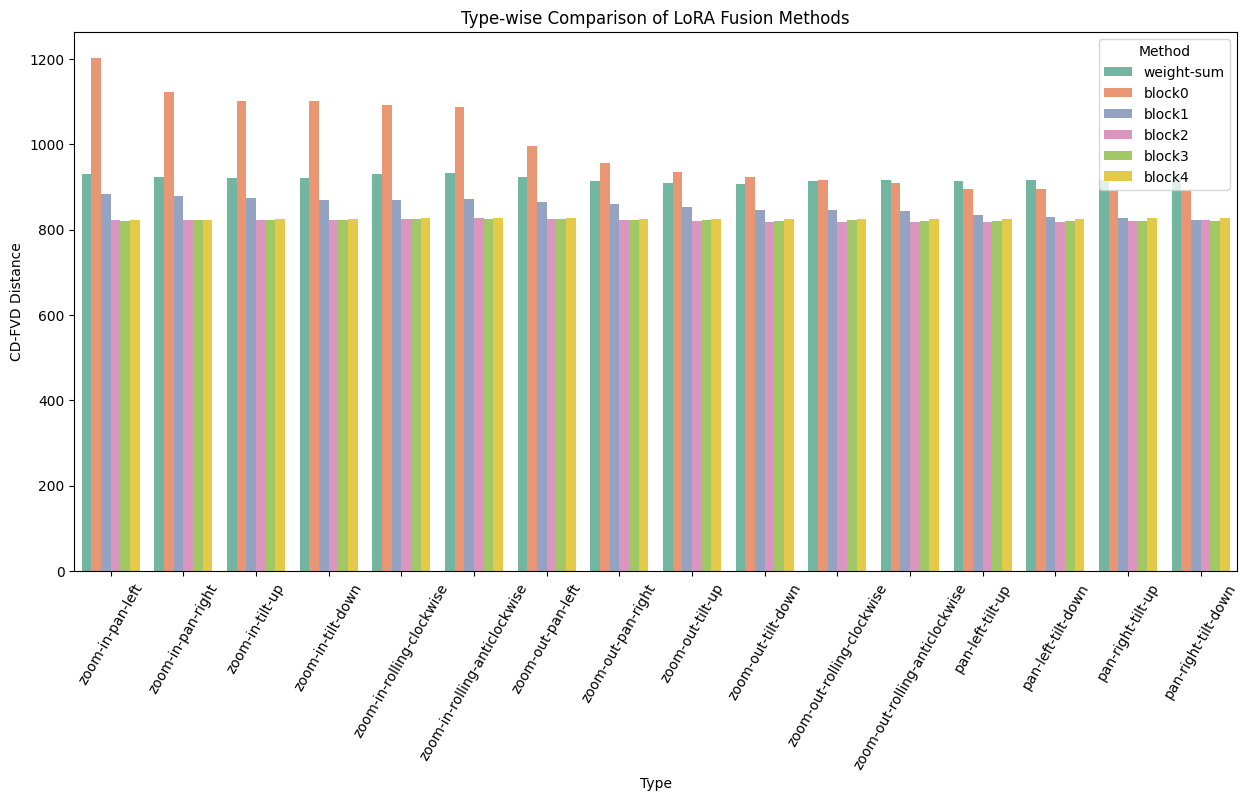

In [99]:
plt.figure(figsize=(15, 7))
sns.barplot(data = comparison_combined, x = "Type", y = "Distance", hue = "Method", palette="Set2")
plt.title("Type-wise Comparison of LoRA Fusion Methods")
plt.ylabel("CD-FVD Distance")
plt.xticks(rotation = 60)
plt.savefig("typewise_comparison.png", bbox_inches="tight")
plt.show()


In [96]:
general_1 = pd.read_csv("data/result/general/all_baseline.csv")
general_2 = pd.read_csv("data/result/general/all_block_combined.csv")

In [97]:
value_list = []
value_list.append(general_1["Baseline"][0])
value_list.append(general_1["Combined_baseline"][0])
for i,_ in enumerate(block_list):
    value_list.append(general_2[f"{i}"][0])

C:\Users\X-tyw\AppData\Local\Temp\ipykernel_11176\3662099721.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = method_list, y = value_list, palette="Set2")


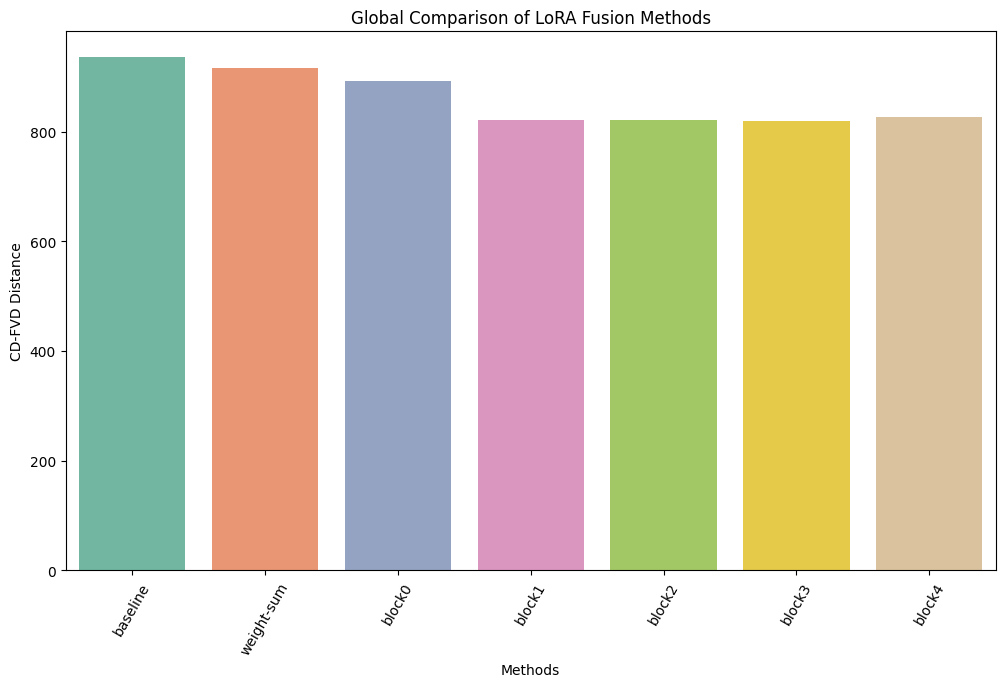

In [100]:
method_list = ["baseline", "weight-sum"] + block_list
plt.figure(figsize=(12, 7))
sns.barplot(x = method_list, y = value_list, palette="Set2")
plt.title("Global Comparison of LoRA Fusion Methods")
plt.ylabel("CD-FVD Distance")
plt.xlabel("Methods")
plt.xticks(rotation = 60)
plt.savefig("global_comparison.png",bbox_inches="tight")
plt.show()

In [1]:
from fvmd import fvmd
import os
import cv2
import numpy as np

In [2]:
def convert_videos_to_npy(folder_list, output_path):
    videos = []
    for folder in folder_list:
        for filename in sorted(os.listdir(folder)):  
            if filename.endswith(".mp4"):
                filepath = os.path.join(folder, filename)
                cap = cv2.VideoCapture(filepath)
                
                frames = []
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
                    frames.append(frame)
                
                cap.release()
                if frames:  
                    videos.append(np.array(frames, dtype=np.uint8))
                    
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # video_array = np.array(videos, dtype=np.uint8)
    video_array = np.stack(videos, axis=0)
    np.savez_compressed(output_path, videos=video_array)
    np.save(output_path, video_array)
    print(f"Saved {output_path} with shape {video_array.shape}")
    return video_array

In [3]:
lora_list = ["zoom-in", "zoom-out", "pan-left", "pan-right", "tilt-up", "tilt-down", "rolling-clockwise", "rolling-anticlockwise"]
prompt_list = ["masterpiece, best quality, highly detailed, ultra detailed, cherry blossom trees, petals falling, gentle breeze, spring season, tranquil park, golden sunlight, peaceful atmosphere, vibrant colors",
               "futuristic city, flying cars, neon glow, holograms, sci-fi, cyberpunk, high-tech buildings, rainy streets, reflections, ultra-detailed, cinematic lighting, masterpiece",
               "majestic snow-covered mountains, crystal-clear lake, morning mist, golden sunrise, serene landscape, pine trees, masterpiece, best quality, highly detailed, ultra realistic",
               "ancient temple ruins, overgrown vines, dense jungle, mystical atmosphere, glowing fireflies, moonlight filtering through trees, fantasy landscape, best quality, ultra detailed",
               "a cozy wooden cabin, deep in the snowy forest, warm light from windows, smoke rising from chimney, peaceful winter night, starry sky, soft snowflakes falling, high quality, ultra detailed",
               "deep underwater scene, glowing jellyfish, coral reef, vibrant marine life, sunlight filtering through the ocean, masterpiece, ultra realistic, high detail",
               "medieval castle, on top of a cliff, dramatic sky, storm approaching, lightning in the distance, cinematic atmosphere, ultra detailed, realistic, best quality",
               "a dragon soaring above a burning city, glowing red eyes, smoke and embers in the air, dramatic lighting, fantasy setting, ultra detailed, masterpiece",
               "a futuristic racing scene, high-speed hovercars, neon trails, cybernetic city backdrop, intense motion blur, ultra realistic, high detail, cinematic lighting",
               "a lone samurai standing under a cherry blossom tree, katana in hand, petals drifting in the wind, golden sunset, historical Japan, ultra detailed, masterpiece",
               "desert landscape, ancient ruins, hot sun, sand dunes, a lone traveler walking, long shadows, masterpiece, ultra detailed, cinematic composition",
               "a spaceship landing on an alien planet, strange glowing plants, massive moons in the sky, futuristic technology, sci-fi adventure, ultra realistic, high quality",
               "a giant whale swimming in the clouds, fantasy world, floating islands, warm golden sunlight, peaceful and dreamlike atmosphere, ultra detailed, masterpiece",
               "a Viking ship sailing through stormy seas, thunder and lightning, massive waves crashing, determined warriors on board, cinematic action, ultra realistic, high detail",
               "a neon-lit alleyway in a cyberpunk city, rain pouring down, reflections on the wet pavement, mysterious figure in a trench coat, atmospheric and moody, ultra detailed, cinematic",
               "a tranquil bamboo forest, soft morning light, mist rolling through, peaceful and zen-like atmosphere, ultra realistic, high detail, masterpiece",
               "an astronaut walking on Mars, vast red desert, distant mountains, dramatic lighting, cinematic science fiction, ultra realistic, masterpiece",
               "a mystical forest at twilight, bioluminescent plants, floating orbs of light, magical and otherworldly atmosphere, ultra detailed, best quality",
               "a luxury yacht sailing in a crystal blue ocean, clear sunny sky, gentle waves, people relaxing on deck, ultra realistic, high detail, cinematic",
               "a street festival at night, colorful lanterns, live performances, fireworks in the sky, people celebrating, ultra detailed, masterpiece, lively and vibrant atmosphere"]
combined_lora_list = ['zoom-in-pan-left',
 'zoom-in-pan-right',
 'zoom-in-tilt-up',
 'zoom-in-tilt-down',
 'zoom-in-rolling-clockwise',
 'zoom-in-rolling-anticlockwise',
 'zoom-out-pan-left',
 'zoom-out-pan-right',
 'zoom-out-tilt-up',
 'zoom-out-tilt-down',
 'zoom-out-rolling-clockwise',
 'zoom-out-rolling-anticlockwise',
 "pan-left-tilt-up",
 "pan-left-tilt-down",
 "pan-right-tilt-up",
 "pan-right-tilt-down"]  ### Exemples of combined_lora_name

block_list = ["block0","block1","block2","block3","block4"]

In [16]:
zoom_in_arrays = convert_videos_to_npy(["data/generated/zoom-in"], "data/arrays/zoom-in.npy")
zoom_out_arrays = convert_videos_to_npy(["data/generated/zoom-out"], "data/arrays/zoom-out.npy")
pan_left_arrays = convert_videos_to_npy(["data/generated/pan-left"], "data/arrays/pan-left.npy")
pan_right_arrays = convert_videos_to_npy(["data/generated/pan-right"], "data/arrays/pan-right.npy")

Saved data/arrays/zoom-in.npy with shape (200, 16, 256, 256, 3)
Saved data/arrays/zoom-out.npy with shape (200, 16, 256, 256, 3)
Saved data/arrays/pan-left.npy with shape (200, 16, 256, 256, 3)
Saved data/arrays/pan-right.npy with shape (200, 16, 256, 256, 3)


In [17]:
for block in block_list:
    for name in combined_lora_list:
        _ = convert_videos_to_npy([f"data/generated/{block}_{name}"], f"data/arrays/{block}_{name}.npy")

Saved data/arrays/block0_zoom-in-pan-left.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-in-pan-right.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-in-tilt-up.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-in-tilt-down.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-in-rolling-clockwise.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-in-rolling-anticlockwise.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-out-pan-left.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-out-pan-right.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-out-tilt-up.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-out-tilt-down.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-out-rolling-clockwise.npy with shape (100, 16, 256, 256, 3)
Saved data/arrays/block0_zoom-out-rolling-anticlockwise.npy with shape (100, 16, 2

In [8]:
test1 = np.load("data/arrays/block0_pan-left-tilt-down.npy")

In [26]:
from fvmd.datasets.video_datasets import VideoDatasetNP
import os
import time
import numpy as np
import fvmd.utils.saverloader as saverloader
from fvmd.nets.pips2 import Pips
import fvmd.utils.improc
import fvmd.utils.misc
import random
from fvmd.utils.basic import print_, print_stats
import torch
from tensorboardX import SummaryWriter
import torch.nn.functional as F
from fire import Fire
from torch.utils.data import Dataset, DataLoader
from loguru import logger
from fvmd.keypoint_tracking import calc_velocity, calc_acceleration,run_tracking
try:
    from torchvision.models._utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

In [ ]:
dataset = VideoDatasetNP(test1)
loader = DataLoader(dataset)
iterloader = iter(loader)

In [ ]:
device = 'cuda:0'
model = Pips(stride=8).to(device)
model = torch.nn.DataParallel(model, device_ids=[0])
model_name = "keypoints_tracking"
writer_x = SummaryWriter("data/fvmd_log" + '/' + model_name, max_queue=10, flush_secs=60)
fvmd.utils.misc.count_parameters(model)

#_ = saverloader.load(init_dir, model.module)
state_dict = load_state_dict_from_url("https://github.com/ljh0v0/FVMD-frechet-video-motion-distance/releases/download/pips2_weights/pips2_weights.pth", progress=True)
model.module.load_state_dict(state_dict['model_state_dict'])
model.eval()

+--------------------------------------------------------+------------+
|                        Modules                         | Parameters |
+--------------------------------------------------------+------------+
|           module.fnet.layer3.0.conv1.weight            |   110592   |
|           module.fnet.layer3.0.conv2.weight            |   147456   |
|           module.fnet.layer3.1.conv1.weight            |   147456   |
|           module.fnet.layer3.1.conv2.weight            |   147456   |
|           module.fnet.layer4.0.conv1.weight            |   147456   |
|           module.fnet.layer4.0.conv2.weight            |   147456   |
|           module.fnet.layer4.1.conv1.weight            |   147456   |
|           module.fnet.layer4.1.conv2.weight            |   147456   |
|                module.fnet.conv2.weight                |   958464   |
|    module.delta_block.first_block_conv.conv.weight     |   275712   |
| module.delta_block.basicblock_list.2.conv2.conv.weight |   196

DataParallel(
  (module): Pips(
    (fnet): BasicEncoder(
      (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (norm2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu1): ReLU(inplace=True)
      (layer1): Sequential(
        (0): ResidualBlock2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace=True)
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (1): ResidualBlock2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64,

In [30]:
dataset_size = len(dataset)
log_freq = dataset_size / 2

In [31]:
def tracking_fullseq(model, rgbs, sw, N = 400, iters=8, S_max=16, name='sample'):
    rgbs = rgbs.cuda().float()  # B,S,C,H,W

    B, S, C, H, W = rgbs.shape
    assert (B == 1)
    # print('this video is %d frames long' % S)

    # zero-vel init

    cur_frame = 0
    done = False
    trajs = []
    velo = []
    acc = []
    while not done:
        end_frame = cur_frame + S_max

        if end_frame > S:
            break
        # print('working on subseq %d:%d' % (cur_frame, end_frame))

        rgb_seq = rgbs[:, cur_frame:end_frame]

        trajs_e = run_tracking(model, rgb_seq, N=N, iters=iters)

        velocity = calc_velocity(trajs_e)
        acceleration = calc_acceleration(trajs_e)
        velo.append(velocity)
        acc.append(acceleration)
        trajs.append(trajs_e)

        # TODO: delete this
        if sw is not None and sw.save_this and cur_frame == 0:
            sw.summ_traj2ds_on_rgbs('outputs/'+name, trajs_e[0:1], fvmd.utils.improc.preprocess_color(rgb_seq[0:1]),
                                    cmap='hot', linewidth=1, show_dots=False)

        cur_frame = cur_frame + S_max - 1

    return trajs, velo, acc

In [33]:
global_step = 0
all_traj_gen = []
all_velo_gen = []
all_acc_gen = []
while global_step < dataset_size:
    global_step += 1
    print(global_step)
    iter_start_time = time.time()
    with torch.no_grad():
        torch.cuda.empty_cache()
    sw_x = fvmd.utils.improc.Summ_writer(
        writer=writer_x,
        global_step=global_step,
        log_freq=log_freq,
        fps=min(16, 8),
        scalar_freq=1,
        just_gif=True)
    try:
        sample_gen = next(iterloader)
    except StopIteration:
        iterloader_gen = iter(loader)
        sample_gen = next(iterloader_gen)
    iter_rtime = time.time() - iter_start_time
    with torch.no_grad():
        trajs_gen, velo_gen, acc_gen = tracking_fullseq(model, sample_gen, sw_x, N=400, iters=16, S_max=16,
                                                        name='{:04d}_sample_gen'.format(global_step))

        all_traj_gen.extend(trajs_gen)
        all_velo_gen.extend(velo_gen)
        all_acc_gen.extend(acc_gen)

In [35]:
all_traj_gen = torch.concatenate(all_traj_gen, dim=0).cpu().numpy()

In [4]:
base_1 = ["zoom-in","zoom-out"]
base_2 = ["pan-left","pan-right"]
sub_1 = ["pan-left", "pan-right", "tilt-up", "tilt-down", "rolling-clockwise", "rolling-anticlockwise"]
sub_2 = ["tilt-up", "tilt-down"]
numeros = [0,1,2,3,4]

In [5]:
def evaluate(base_loras, sub_loras, block_nums):
    distances = {}
    for base in base_loras:
        for block in block_nums:
            for sub in sub_loras:
                fvmd_value = fvmd(log_dir="data/fvmd_log", gen_path=f"data/arrays/block{block}_{base}-{sub}.npz", gt_path=f"data/arrays/{base}.npz")
                distances[(base,sub,block)] = fvmd_value
    return distances

In [6]:
fvmd_1 = evaluate(base_1,sub_1,numeros)
fvmd_2 = evaluate(base_2,sub_2,numeros)

+--------------------------------------------------------+------------+
|                        Modules                         | Parameters |
+--------------------------------------------------------+------------+
|           module.fnet.layer3.0.conv1.weight            |   110592   |
|           module.fnet.layer3.0.conv2.weight            |   147456   |
|           module.fnet.layer3.1.conv1.weight            |   147456   |
|           module.fnet.layer3.1.conv2.weight            |   147456   |
|           module.fnet.layer4.0.conv1.weight            |   147456   |
|           module.fnet.layer4.0.conv2.weight            |   147456   |
|           module.fnet.layer4.1.conv1.weight            |   147456   |
|           module.fnet.layer4.1.conv2.weight            |   147456   |
|                module.fnet.conv2.weight                |   958464   |
|    module.delta_block.first_block_conv.conv.weight     |   275712   |
| module.delta_block.basicblock_list.2.conv2.conv.weight |   196

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
rows = []
for i, base in enumerate(base_1):
    for j, sub in enumerate(sub_1):
        row = [base, sub] + [fvmd_1[(base, sub, block)] for block in numeros]
        rows.append(row)
for i, base in enumerate(base_2):
    for j, sub in enumerate(sub_2):
        row = [base, sub] + [fvmd_2[(base, sub, block)] for block in numeros]
        rows.append(row)
columns = ["Base LoRA", "Sub LoRA"] + numeros
df = pd.DataFrame(rows, columns=columns)

print(df)